# Fuzzy Logic Model for Tip Prediction

This notebook presents an implementation of a simple fuzzy inference system (0-order Takagi-Sugeno-Kang model) designed to estimate the value of a tip based on qualitative assessments of food and service quality.

The model includes the following components:

- Definition of input variables along with their value ranges.
- Construction of fuzzy sets for each input variable, using triangular and trapezoidal membership functions.
- Formulation of fuzzy rules that map combinations of input fuzzy sets to numeric outputs (tip values).
- Evaluation of rule activation levels (truth degrees) based on the given inputs.
- Aggregation of rule outputs according to the TSK model to produce a final prediction.

As an application example, the model estimates a tip (in the range of 0–15%) based on two input criteria:
- **Food quality** rated from 0 to 10.
- **Service quality** rated from 0 to 10.

This setup demonstrates how fuzzy logic can be applied to decision-making in situations with subjective or imprecise input data.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## 1. FuzzySet
The `FuzzySet` class represents a fuzzy set, which is a set without a crisp boundary. It defines a particular type of membership function (e.g., triangular or trapezoidal) that determines how each input value relates to the fuzzy set.

### Attributes:
- **name**: The name of the fuzzy set (e.g., "good", "average", "bad").
- **mf_type**: The type of membership function (e.g., 'triangular', 'trapezoidal').
- **params**: Parameters defining the shape of the membership function (e.g., the vertices of the triangle or trapezoid).

### Methods:
- **membership(x)**: This method calculates the membership degree of a given input `x` to the fuzzy set based on its membership function. It handles both triangular and trapezoidal membership functions, returning a value between 0 and 1 that indicates the degree of membership.

In [ ]:
class FuzzySet:
    def __init__(self, name, mf_type, params):
        self.name = name
        self.mf_type = mf_type
        self.params = params

    def membership(self, x):
        if self.mf_type == 'triangular':
            a, b, c = self.params
            if a <= x <= c:
                if x < b:
                    return (x - a) / (b - a)
                else:
                    return (c - x) / (c - b)
            else:
                return 0
        elif self.mf_type == 'trapezoidal':
            a, b, c, d = self.params
            if a <= x <= d:
                if a <= x < b:
                    return (x - a) / (b - a)
                elif b <= x <= c:
                    return 1
                else:
                    return (d - x) / (d - c)
            else:
                return 0

## 2. FuzzyVariable Class
The `FuzzyVariable` class defines a fuzzy variable, which can take on fuzzy values based on the fuzzy sets associated with it. This class is used to encapsulate the concept of a variable that can have degrees of membership in different fuzzy sets.

### Attributes:
- **name**: The name of the fuzzy variable (e.g., "food quality").
- **min_val**: The minimum value the fuzzy variable can take.
- **max_val**: The maximum value the fuzzy variable can take.
- **fuzzy_sets**: A list to hold the fuzzy sets associated with this variable.

### Methods:
- **add_fuzzy_set(fuzzy_set)**: This method adds a fuzzy set to the list of fuzzy sets for the variable.
- **fuzzify(value)**: This method calculates the degree of membership for a given crisp input value across all associated fuzzy sets, returning a dictionary of membership values.
- **plot()**: This method visualizes the fuzzy sets using a graph, showing the degree of membership for each fuzzy set across the range of possible values.

In [ ]:
class FuzzyVariable:
    def __init__(self, name, min_val, max_val):
        self.name = name
        self.min_val = min_val
        self.max_val = max_val
        self.fuzzy_sets = []

    def add_fuzzy_set(self, fuzzy_set):
        self.fuzzy_sets.append(fuzzy_set)

    def fuzzify(self, value):
        membership_values = {}
        for fuzzy_set in self.fuzzy_sets:
            membership_values[fuzzy_set.name] = fuzzy_set.membership(value)
        return membership_values

    def plot(self):
        x = np.linspace(self.min_val, self.max_val, 1000)
        plt.figure(figsize=(8, 6))

        for fuzzy_set in self.fuzzy_sets:
            y = np.array([fuzzy_set.membership(val) for val in x])
            plt.plot(x, y, label=fuzzy_set.name)

        plt.title(f"Fuzzy sets for {self.name}")
        plt.xlabel(self.name)
        plt.ylabel("Membership degree")
        plt.legend()
        plt.grid(True)
        plt.show()

## 3. FuzzyRule Class
The `FuzzyRule` class represents a fuzzy rule that defines a relationship between fuzzy variables and their fuzzy sets. It consists of antecedents (conditions) and a consequent (conclusion).

### Attributes:
- **antecedents**: A list of tuples representing the conditions of the rule, where each tuple consists of a variable name and a fuzzy set name.
- **consequent**: The output value or fuzzy set that corresponds to the antecedents when the rule is activated.

### Methods:
- **evaluate(inputs)**: This method evaluates the strength of the rule given a set of input membership values. It calculates the minimum membership value among all antecedents, which represents the rule's overall activation strength.


In [ ]:
class FuzzyRule:
    def __init__(self, antecedents, consequent):
        self.antecedents = antecedents
        self.consequent = consequent

    def evaluate(self, inputs):
        antecedent_values = []
        for variable, fuzzy_set in self.antecedents:
            membership_value = inputs[variable][fuzzy_set]
            antecedent_values.append(membership_value)
        return min(antecedent_values)

## 4. FuzzyInferenceSystem Class
The `FuzzyInferenceSystem` class encapsulates the overall fuzzy inference system. It manages the rules and performs inference based on the input values.

### Attributes:
- **rules**: A list of fuzzy rules that define the logic of the fuzzy inference system.

### Methods:
- **add_rule(rule)**: This method adds a fuzzy rule to the system.
- **infer(inputs)**: This method computes the final output based on the inputs and the defined rules. It calculates the numerator and denominator to determine the overall output value. The numerator is the weighted sum of the consequent values based on the strength of the rules, while the denominator is the total strength of the rules. If the denominator is zero (no rules activated), it returns 0; otherwise, it returns the ratio of the numerator to the denominator.


In [ ]:
class FuzzyInferenceSystem:
    def __init__(self):
        self.rules = []

    def add_rule(self, rule):
        self.rules.append(rule)

    def infer(self, inputs):
        numerator = 0
        denominator = 0

        print("=== Inference Process ===")
        for rule_idx, rule in enumerate(self.rules):
            rule_strength = rule.evaluate(inputs)
            print(f"Rule {rule_idx + 1}: {rule.antecedents} -> {rule.consequent}")
            print(f"  Rule strength: {rule_strength:.4f}")

            numerator += rule_strength * rule.consequent
            denominator += rule_strength

            print(f"  Contribution to numerator: {rule_strength * rule.consequent:.4f}")
            print(f"  Running numerator: {numerator:.4f}")
            print(f"  Running denominator: {denominator:.4f}")
            print()

        if denominator == 0:
            print("No rule was activated (denominator is zero).")
            return 0

        result = numerator / denominator
        print(f"Suggested tip: {result:.2f}%")
        return result

Now we can build our own **Fuzzy Model**.

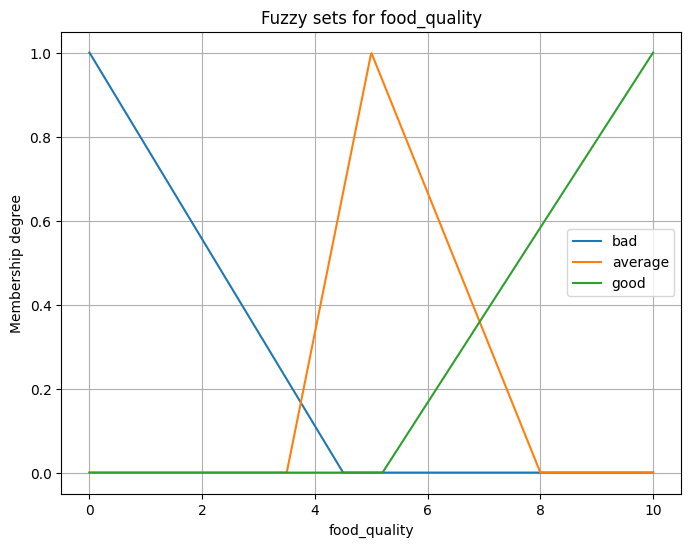

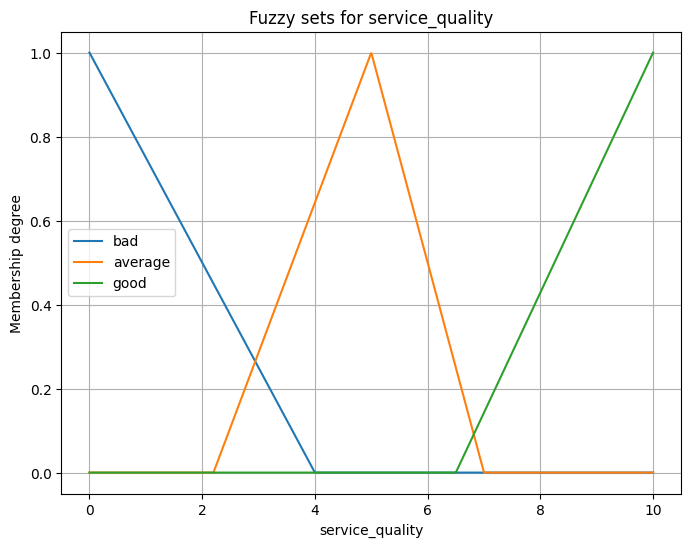

In [ ]:
## Creating fuzzy variables
food_quality = FuzzyVariable('food_quality', 0, 10)

food_quality.add_fuzzy_set(FuzzySet('bad', 'triangular', [0, 0, 4.5]))
food_quality.add_fuzzy_set(FuzzySet('average', 'triangular', [3.5, 5, 8]))
food_quality.add_fuzzy_set(FuzzySet('good', 'triangular', [5.2, 10, 10.1]))

service_quality = FuzzyVariable('service_quality', 0, 10)

service_quality.add_fuzzy_set(FuzzySet('bad', 'triangular', [0, 0, 4]))
service_quality.add_fuzzy_set(FuzzySet('average', 'triangular', [2.2, 5, 7]))
service_quality.add_fuzzy_set(FuzzySet('good', 'triangular', [6.5, 10, 10.1]))

# Plotting the fuzzy variables to visualize the membership functions
food_quality.plot()
service_quality.plot()

In [ ]:
# Creating a fuzzy inference system to process the rules
fuzzy_system = FuzzyInferenceSystem()

# Adding fuzzy rules
fuzzy_system.add_rule(FuzzyRule([('food_quality', 'good'), ('service_quality', 'good')], 15))
fuzzy_system.add_rule(FuzzyRule([('food_quality', 'good'), ('service_quality', 'average')], 13))
fuzzy_system.add_rule(FuzzyRule([('food_quality', 'good'), ('service_quality', 'bad')], 11))
fuzzy_system.add_rule(FuzzyRule([('food_quality', 'average'), ('service_quality', 'good')], 9))
fuzzy_system.add_rule(FuzzyRule([('food_quality', 'average'), ('service_quality', 'average')], 7))
fuzzy_system.add_rule(FuzzyRule([('food_quality', 'average'), ('service_quality', 'bad')], 5))
fuzzy_system.add_rule(FuzzyRule([('food_quality', 'bad'), ('service_quality', 'good')], 3))
fuzzy_system.add_rule(FuzzyRule([('food_quality', 'bad'), ('service_quality', 'average')], 2))
fuzzy_system.add_rule(FuzzyRule([('food_quality', 'bad'), ('service_quality', 'bad')], 0))

# Defining input values for fuzzification
inputs = {
    'food_quality': food_quality.fuzzify(7),
    'service_quality': service_quality.fuzzify(3)
}

tip_percentage = fuzzy_system.infer(inputs)

=== Inference Process ===
Rule 1: [('food_quality', 'good'), ('service_quality', 'good')] -> 15
  Rule strength: 0.0000
  Contribution to numerator: 0.0000
  Running numerator: 0.0000
  Running denominator: 0.0000

Rule 2: [('food_quality', 'good'), ('service_quality', 'average')] -> 13
  Rule strength: 0.2857
  Contribution to numerator: 3.7143
  Running numerator: 3.7143
  Running denominator: 0.2857

Rule 3: [('food_quality', 'good'), ('service_quality', 'bad')] -> 11
  Rule strength: 0.2500
  Contribution to numerator: 2.7500
  Running numerator: 6.4643
  Running denominator: 0.5357

Rule 4: [('food_quality', 'average'), ('service_quality', 'good')] -> 9
  Rule strength: 0.0000
  Contribution to numerator: 0.0000
  Running numerator: 6.4643
  Running denominator: 0.5357

Rule 5: [('food_quality', 'average'), ('service_quality', 'average')] -> 7
  Rule strength: 0.2857
  Contribution to numerator: 2.0000
  Running numerator: 8.4643
  Running denominator: 0.8214

Rule 6: [('food_qual

### Summary

In this case, the **suggested tip** was **9.07%**, which is a reasonable and interpretable result given the average quality of food and service.

The result can be considered **satisfactory**, indicating that the model performs as expected and provides meaningful inferences from the fuzzy rule base.
